# extendXarray.GridVectors()
*NOTE: This is a work in progress. Functionality is robust but not fully-featured. Stay tuned.*

This notebook documents the functionality of the `GridVectors()` class of the **extendXarray** project.

The class is initialized with an input `xarray.Dataset` object and the names (strings) of the x and y dimensions. Class object contains some spatial metadata and an empty GDAL raster object that matches exactly the grid within the input dataset. 

Most of these should be self-explanatory. Will provide more detail as time allows:
```
# inputs (y and x dimension objects grabbed using input strings)
self.nc
self.xdim 
self.ydim

# spatial metadata
self.ncols
self.nrows
self.ymax
self.ymin
self.xmax
self.xmin

# x and y cell sizes and GDAL geotransform definition
self.yres = ( self.ymax - self.ymin ) / float( self.nrows )
self.xres = ( self.xmax - self.xmin ) / float( self.ncols )
self.geotransform = ( self.xmin , self.xres , 0 , self.ymax , 0 , -self.yres )

# empty raster
self.dst_ds
```

Class methods return a number of xarray structures. Each takes the path to an input shapefile (string), and either a burn value (integer) that will represent the shapefile coverage *OR* an field name (string) that indicates which attribute in the Shapefile contains the burn values (field values must be integers).

##### The first two return arrays:

`object.asNumpyArray()`
```
asNumpyArray( self , <input shapefile path> , <burn integer OR attribute field> )
```

`object.asDataArray()`
```
asDataArray( self , <input shapefile path> , <burn integer OR attribute field> )
```

##### The second two return a copy of the input `xarray.Dataset` object containing the new coordinate or array:

`object.asDatasetCoord()`
```
asDatasetCoord( self , <input shapefile path> , <burn integer OR attribute field> , <name of output coordinate> , <(optional) attributes as python dictionary> )
```

`object.asDatasetVariable()`
```
asDatasetVariable( self , <input shapefile path> , <burn integer OR attribute field> , <name of output coordinate> , <(optional) attributes as python dictionary> )
```
-------------------------------
**Test the methods:** 

You'll need to import `json` if you want to test the attributes argument. I saved a dictionary of attributes for the humidity_index output layers as a JSON file at:
`data/json/humidity_index_attributes.json`

Import `xarray`,`numpy` and get some input data:

In [1]:
import xarray,numpy #,json
%matplotlib inline

nc = xarray.open_dataset( 
    "data/netcdf/MOD11A1.006_1km_aid0001.nc" , 
    mask_and_scale = False , 
    chunks = { 'time':5, 'ydim': 1000, 'xdim': 1000 } 
)

humidity_index_shp = "data/shapefile/humidity_index-sinu.shp"
#humidity_index_attrs = json.load( open( "data/json/humidity_index_attributes.json" , "r" ) )

**Import the class `extendXarray.GridVectors()`**

In [2]:
from extendXarray.classes import GridVectors as GridVectors
GridVectors

extendXarray.classes.GridVectors

------------------------------
Note: the names of the x and y dimensions in our input dataset are 'xdim' and 'ydim', respectively.

**Initialize a GridVectors() class:**

In [3]:
example_GridVectors = GridVectors( nc , 'xdim' , 'ydim' )
example_GridVectors

---------------------------------------
**asNumpyArray()**

Pass the string containing the path to the humidity index shapefile and the string "GRIDCODE" that gives the output array values:

In [4]:
example_NumpyArray = example_GridVectors.asNumpyArray( humidity_index_shp , "GRIDCODE" )

print( example_NumpyArray )
print( "\nInput y dim size:\t\t" + str(nc.ydim.size) + "\nOutput array y dim size:\t" + str( numpy.size( example_NumpyArray, axis = 0 ) ) )
print( "\nInput x dim size:\t\t" + str(nc.xdim.size) + "\nOutput array x dim size:\t" + str( numpy.size( example_NumpyArray, axis = 1 ) ) )
print( "\nUnique values:\t" + str( numpy.unique( example_NumpyArray ) ) )

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Input y dim size:		2966
Output array y dim size:	2966

Input x dim size:		6381
Output array x dim size:	6381

Unique values:	[0 2 3 4 5 6]


See that the length of the x and y dimensions of the output array are equal to those in the input dataset. But don't ask me why the humidity index shapefile doesn't have a GRIDCODE value of 1...

We'll assume that the dimensions are equal for the remaining examples.

**asDataArray()**

This method takes the same inputs but returns a `xarray.DataArray` object. Optionally, pass a python dictionary to the `attrs` keyword argument to set attributes for the output array:

In [5]:
tmp = example_GridVectors.asDataArray( humidity_index_shp , "GRIDCODE" )
tmp

<xarray.DataArray (ydim: 2966, xdim: 6381)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * ydim     (ydim) float64 5.492e+06 5.491e+06 5.49e+06 ... 2.745e+06 2.744e+06
  * xdim     (xdim) float64 -1.105e+07 -1.105e+07 ... -5.136e+06 -5.135e+06

Plot the output this time:

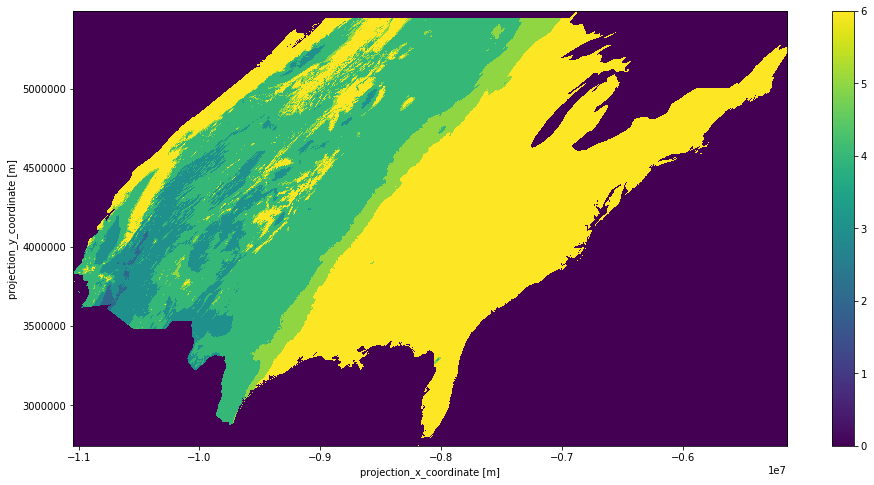

In [6]:
tmp.plot.imshow(aspect=2, size=8)

**Also try the binary mask option. Pass an integer instead of an attribute field:**

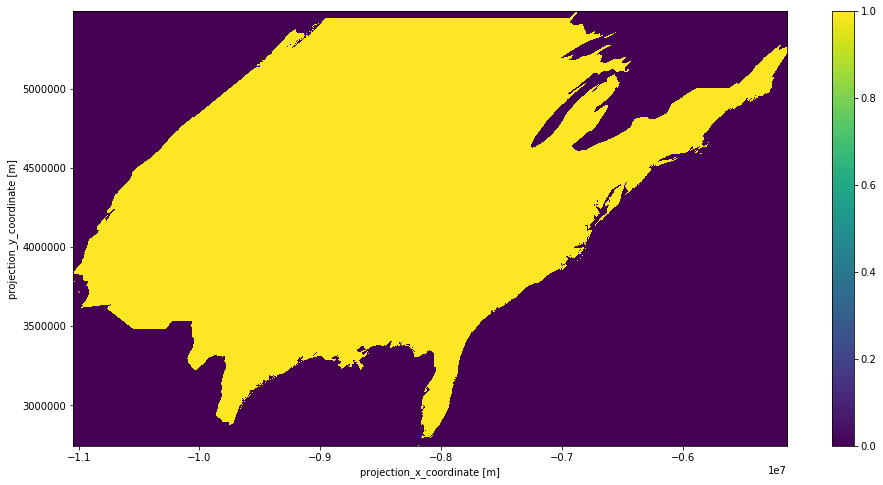

In [7]:
tmp = example_GridVectors.asDataArray( humidity_index_shp , 1 )
tmp.plot.imshow(aspect=2, size=8)

------------------------------------------
**asDatasetCoord()**

This method requires an extra input: a name for the coordinate to write to a copy of the input `xarray.Dataset`. A new dataset object is returned with the added coordinate. Again, you have the option to pass a python dictionary to the `attrs` keyword argument to set attributes for the output array.

Let's use the division-level Bailey's Ecoregions this time:

In [8]:
baileys_ecoregions_shp = "data/shapefile/baileys_ecoregions-sinu.shp"

example_GridVectors.asDatasetCoord( baileys_ecoregions_shp , "DIVISIONI" , "ecoregions" )

<xarray.Dataset>
Dimensions:        (time: 1717, xdim: 6381, ydim: 2966)
Coordinates:
  * time           (time) object 2000-06-01 00:00:00 ... 2018-08-31 00:00:00
  * ydim           (ydim) float64 5.492e+06 5.491e+06 ... 2.745e+06 2.744e+06
  * xdim           (xdim) float64 -1.105e+07 -1.105e+07 ... -5.135e+06
    ecoregions     (ydim, xdim) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    crs            int8 ...
    LST_Day_1km    (time, ydim, xdim) int32 dask.array<shape=(1717, 2966, 6381), chunksize=(5, 1000, 1000)>
    LST_Night_1km  (time, ydim, xdim) int32 dask.array<shape=(1717, 2966, 6381), chunksize=(5, 1000, 1000)>
    QC_Day         (time, ydim, xdim) int16 dask.array<shape=(1717, 2966, 6381), chunksize=(5, 1000, 1000)>
    QC_Night       (time, ydim, xdim) int16 dask.array<shape=(1717, 2966, 6381), chunksize=(5, 1000, 1000)>
Attributes:
    title:        MOD11A1.006 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active A

**asDatasetVariable()**

This method also returns a new `xarray.Dataset`, but this time the rasterized shapefile is stored as a variable:

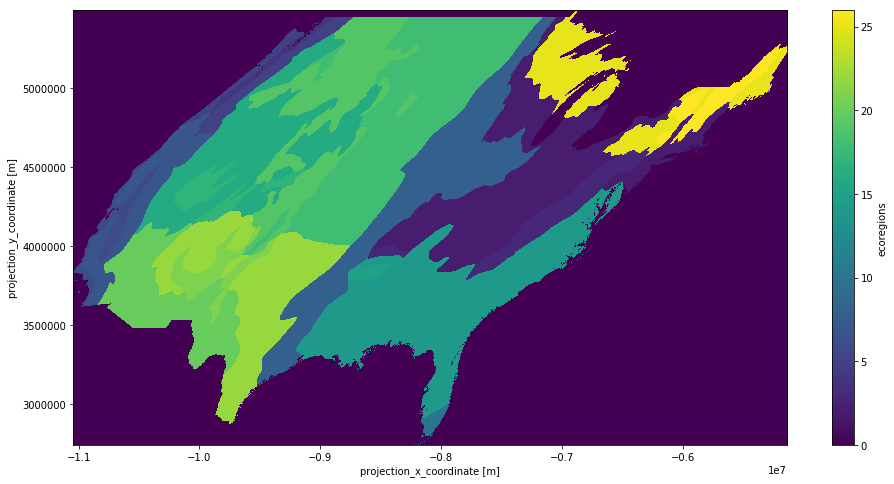

In [9]:
tmp = example_GridVectors.asDatasetVariable( baileys_ecoregions_shp , "DIVISIONI" , "ecoregions" )
tmp
tmp["ecoregions"].plot.imshow(aspect=2, size=8)